# Controlling for "X"? 

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
import statsmodels.formula.api as sm
from stargazer.stargazer import Stargazer  # noqa: F401

sns.set_theme(style="darkgrid")

## Data Generating Process

In [12]:
df = pd.DataFrame()
n = 10000

# Covariates
df["pareduc"] = np.random.normal(loc=14, scale=3, size=n).round()
df["HHinc"] = skewnorm.rvs(5, loc=3, scale=4, size=n).round()
df["IQ"] = np.random.normal(100, 10, size=n).round()

# Childhood Monthly Reading
df["read"] = (
    -25
    + 0.3 * df["pareduc"]
    + 2 * df["HHinc"]
    + 0.2 * df["IQ"]
    + np.random.normal(0, 2, size=n)
).round()

df = df[(df["read"] >= 0) & (df["read"] <= 30)]

# Education Attainment
df["educ"] = (
    -15
    + 0.2 * df["read"]
    + 0.1 * df["pareduc"]
    + 1 * df["HHinc"]
    + 0.2 * df["IQ"]
    + df["read"] / 15 * np.random.normal(0, 2, size=len(df)).round()
)

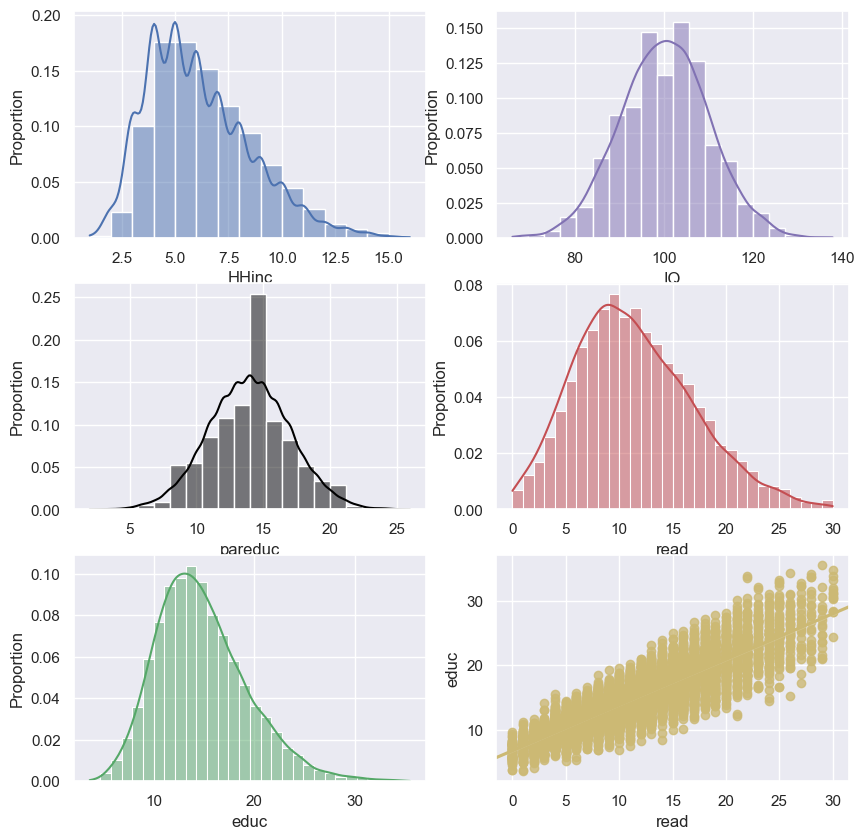

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
sns.histplot(df.HHinc, color="b", ax=ax[0, 0], bins=15, stat="proportion", kde=True)
sns.histplot(df.IQ, color="m", ax=ax[0, 1], bins=20, stat="proportion", kde=True)
sns.histplot(
    df.pareduc, color="black", ax=ax[1, 0], bins=20, stat="proportion", kde=True
)
sns.histplot(df.read, color="r", ax=ax[1, 1], bins=30, stat="proportion", kde=True)
sns.histplot(df.educ, color="g", ax=ax[2, 0], bins=30, stat="proportion", kde=True)
sns.regplot(data=df, x="read", y="educ", color="y", truncate=False, ax=ax[2, 1])
plt.show()

## Regression Analysis

In [14]:
# Naive Regression
naive = sm.ols("educ~read", data=df).fit(cov_type="HC3")
print(naive.summary())

                            OLS Regression Results                            
Dep. Variable:                   educ   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                 2.181e+04
Date:                Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:20:24   Log-Likelihood:                -21840.
No. Observations:                9897   AIC:                         4.368e+04
Df Residuals:                    9895   BIC:                         4.370e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7724      0.049    138.123      0.0

In [15]:
# Multiple Regression
multiple = sm.ols("educ~read+pareduc+HHinc+IQ", data=df).fit(cov_type="HC3")
print(multiple.summary())

                            OLS Regression Results                            
Dep. Variable:                   educ   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     8963.
Date:                Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:20:24   Log-Likelihood:                -19246.
No. Observations:                9897   AIC:                         3.850e+04
Df Residuals:                    9892   BIC:                         3.854e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.8646      0.287    -51.836      0.0

In [16]:
# FWL Theorem
read = sm.ols("read~pareduc+HHinc+IQ", data=df).fit(cov_type="HC3")
df["read_star"] = read.resid

educ = sm.ols("educ~pareduc+HHinc+IQ", data=df).fit(cov_type="HC3")
df["educ_star"] = educ.resid

FWL = sm.ols("educ_star ~ read_star", data=df).fit(cov_type="HC3")
print(FWL.summary())

                            OLS Regression Results                            
Dep. Variable:              educ_star   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     593.7
Date:                Thu, 19 Oct 2023   Prob (F-statistic):          2.15e-127
Time:                        17:20:24   Log-Likelihood:                -19246.
No. Observations:                9897   AIC:                         3.850e+04
Df Residuals:                    9895   BIC:                         3.851e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.017e-14      0.017  -2.36e-12      1.0

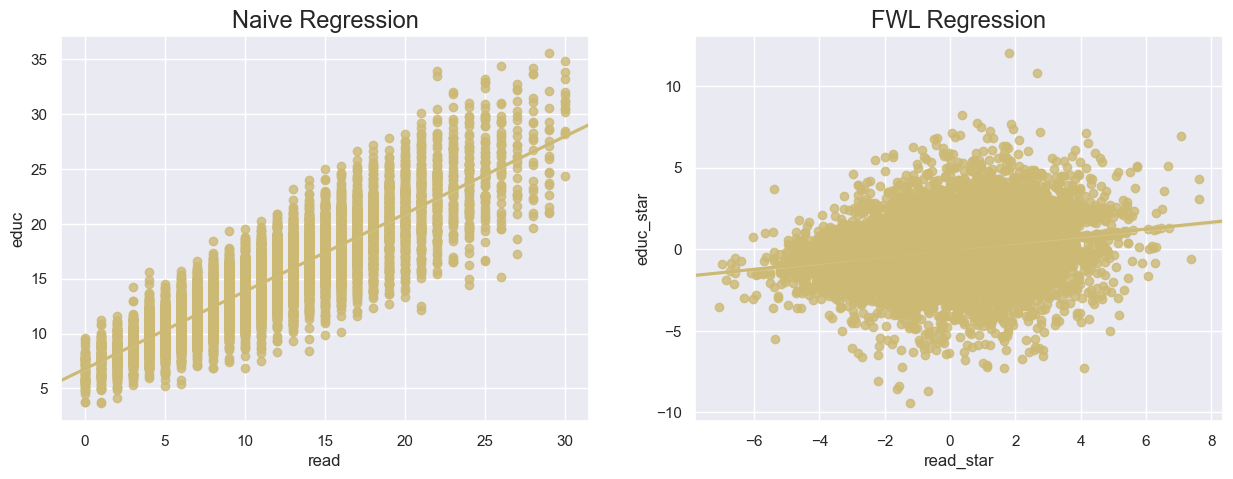

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))  # ,dpi=1000)
ax[0].set_title("Naive Regression", fontsize=17)
ax[1].set_title("FWL Regression", fontsize=17)
sns.regplot(data=df, x="read", y="educ", color="y", truncate=False, ax=ax[0])
sns.regplot(data=df, x="read_star", y="educ_star", color="y", truncate=False, ax=ax[1])
plt.show()

## Write Results to Table

In [18]:
# file = open("table.html", "w")

# order = ["read", "read_star", "HHinc", "pareduc", "IQ", "Intercept"]
# columns = ["Naive OLS", "Multiple OLS", "FWL"]
# rename = {
#     "read": "Read (Days/Month)",
#     "read_star": "Read*",
#     "hhincome": "HH Income",
#     "pareduc": "Avg. Parents Education (Yrs)",
# }

# regtable = Stargazer([naive, multiple, FWL])
# regtable.covariate_order(order)
# regtable.custom_columns(columns, [1, 1, 1])
# regtable.rename_covariates(rename)
# regtable.show_degrees_of_freedom(True)
# regtable.title("The Simulated Effect of Childhood Reading on Educational Attainment")

# file.write(regtable.render_html())
# file.close()

## Cover Photo

C:\Users\jakep\AppData\Local\Temp\ipykernel_27536\412979704.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','','','','','','','',''])
C:\Users\jakep\AppData\Local\Temp\ipykernel_27536\412979704.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['','','','','','','','',''])


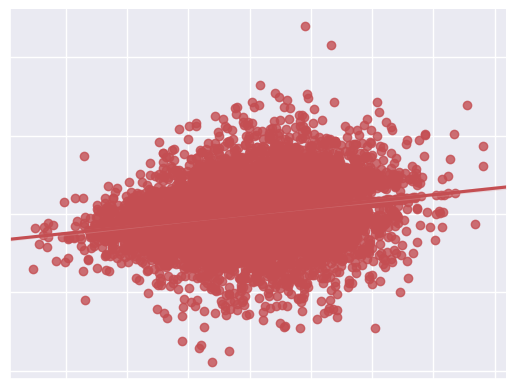

In [19]:
fig, ax = plt.subplots()  # dpi=600,figsize=(7,7))

sns.regplot(data=df, x="read_star", y="educ_star", color="r", truncate=False, ax=ax)

ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels(["", "", "", "", "", "", "", "", ""])
ax.set_yticklabels(["", "", "", "", "", "", "", "", ""])
plt.show()